<a href="https://colab.research.google.com/github/adap7/IRTM/blob/main/IRTM_Tutorial_query_2024_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start by copying this into your Google Drive!!

# Information Retrieval & Text Mining
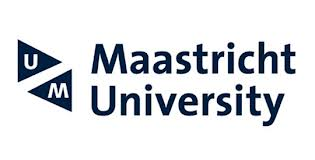
## Notebook 3

Version 2024-2025

Adapted and updated from [here](https://github.com/castorini/anserini-notebooks-afirm2020)

# Indexing


We start by reindexing the dataset as we did in the previous notebook so we can query it:

In [ ]:
!git clone https://github.com/castorini/anserini.git
!cd anserini && git checkout ad5ba1c76196436f8a0e28efdb69960d4873efe3

Cloning into 'anserini'...
remote: Enumerating objects: 48214, done.
remote: Counting objects: 100% (1241/1241), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 48214 (delta 1104), reused 857 (delta 845), pack-reused 46973 (from 2)
Receiving objects: 100% (48214/48214), 93.71 MiB | 13.40 MiB/s, done.
Resolving deltas: 100% (36776/36776), done.
Note: switching to 'ad5ba1c76196436f8a0e28efdb69960d4873efe3'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at ad5ba1c7 Release notes for v0.9.2 (#

In [ ]:
!apt-get install -y openjdk-11-jdk-headless
%env JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.26+4-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
env: JAVA_HOME=/usr/lib/jvm/java-11-openjdk-amd64


In [ ]:
!apt-get install -q maven

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libaopalliance-java libapache-pom-java libatinject-jsr330-api-java libcdi-api-java
  libcommons-cli-java libcommons-io-java libcommons-lang3-java libcommons-parent-java
  libgeronimo-annotation-1.3-spec-java libgeronimo-interceptor-3.0-spec-java libguava-java
  libguice-java libhawtjni-runtime-java libjansi-java libjansi-native-java libjsr305-java
  libmaven-parent-java libmaven-resolver-java libmaven-shared-utils-java libmaven3-core-java
  libplexus-cipher-java libplexus-classworlds-java libplexus-component-annotations-java
  libplexus-interpolation-java libplexus-sec-dispatcher-java libplexus-utils2-java
  libsisu-inject-java libsisu-plexus-java libslf4j-java libwagon-file-java
  libwagon-http-shaded-java libwagon-provider-api-java
Suggested packages:
  libaopalliance-java-doc libatinject-jsr330-api-java-doc libel-api-java libcommons-io-java-doc
  l

In [ ]:
!cd anserini && mvn clean package appassembler:assemble | grep "BUILD"

[INFO] BUILD SUCCESS


In [ ]:
!mkdir -p data
!wget https://msmarco.z22.web.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
!tar -xvf collectionandqueries.tar.gz -C data

--2025-04-01 16:45:24--  https://msmarco.z22.web.core.windows.net/msmarcoranking/collectionandqueries.tar.gz
Resolving msmarco.z22.web.core.windows.net (msmarco.z22.web.core.windows.net)... 20.150.34.1
Connecting to msmarco.z22.web.core.windows.net (msmarco.z22.web.core.windows.net)|20.150.34.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1057717952 (1009M) [application/gzip]
Saving to: ‘collectionandqueries.tar.gz’

collectionandquerie 100%[===================>]   1009M  63.7MB/s    in 20s     

2025-04-01 16:45:44 (50.6 MB/s) - ‘collectionandqueries.tar.gz’ saved [1057717952/1057717952]

collection.tsv
qrels.dev.small.tsv
qrels.train.tsv
queries.dev.small.tsv
queries.dev.tsv
queries.eval.small.tsv
queries.eval.tsv
queries.train.tsv


In [ ]:
!cd anserini && python ./src/main/python/msmarco/convert_collection_to_jsonl.py \
 --collection_path ../data/collection.tsv --output_folder ../data/collection_jsonl

Converting collection...
Converted 0 docs in 1 files
Converted 100000 docs in 1 files
Converted 200000 docs in 1 files
Converted 300000 docs in 1 files
Converted 400000 docs in 1 files
Converted 500000 docs in 1 files
Converted 600000 docs in 1 files
Converted 700000 docs in 1 files
Converted 800000 docs in 1 files
Converted 900000 docs in 1 files
Converted 1000000 docs in 2 files
Converted 1100000 docs in 2 files
Converted 1200000 docs in 2 files
Converted 1300000 docs in 2 files
Converted 1400000 docs in 2 files
Converted 1500000 docs in 2 files
Converted 1600000 docs in 2 files
Converted 1700000 docs in 2 files
Converted 1800000 docs in 2 files
Converted 1900000 docs in 2 files
Converted 2000000 docs in 3 files
Converted 2100000 docs in 3 files
Converted 2200000 docs in 3 files
Converted 2300000 docs in 3 files
Converted 2400000 docs in 3 files
Converted 2500000 docs in 3 files
Converted 2600000 docs in 3 files
Converted 2700000 docs in 3 files
Converted 2800000 docs in 3 files
Conv

In [ ]:
!cd anserini && sh target/appassembler/bin/IndexCollection -collection JsonCollection -input ../data/collection_jsonl \
 -index ../indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs -generator DefaultLuceneDocumentGenerator -threads 9 \
 -storePositions -storeDocvectors -storeRaw

2025-04-01 16:47:33,327 INFO  [main] index.IndexCollection (IndexCollection.java:636) - Setting log level to INFO
2025-04-01 16:47:33,331 INFO  [main] index.IndexCollection (IndexCollection.java:639) - Starting indexer...
2025-04-01 16:47:33,332 INFO  [main] index.IndexCollection (IndexCollection.java:640) - ============ Loading Parameters ============
2025-04-01 16:47:33,332 INFO  [main] index.IndexCollection (IndexCollection.java:641) - DocumentCollection path: ../data/collection_jsonl
2025-04-01 16:47:33,333 INFO  [main] index.IndexCollection (IndexCollection.java:642) - CollectionClass: JsonCollection
2025-04-01 16:47:33,334 INFO  [main] index.IndexCollection (IndexCollection.java:643) - Generator: DefaultLuceneDocumentGenerator
2025-04-01 16:47:33,334 INFO  [main] index.IndexCollection (IndexCollection.java:644) - Threads: 9
2025-04-01 16:47:33,335 INFO  [main] index.IndexCollection (IndexCollection.java:645) - Stemmer: porter
2025-04-01 16:47:33,335 INFO  [main] index.IndexCollec

# Querying

In this exercise, we are going to first interactively query the index and then produce a TREC run with [Pyserini](https://github.com/castorini/pyserini), the Python interface to Anserini.

## Setup

Install Python dependencies (again - remember that each notebook instantiates a virtual machine of its own):

In [ ]:
!pip install pyjnius==1.2.1
!pip install pyserini==0.9.2

Instead of building anserini from scratch, we download the fatjar from the maven repository and store it locally:

In [ ]:
!wget -O anserini-0.9.2-fatjar.jar https://search.maven.org/remotecontent?filepath=io/anserini/anserini/0.9.2/anserini-0.9.2-fatjar.jar

Let's point Pyserini to the Anserini jar that we have just installed:

In [ ]:
import os
os.environ['ANSERINI_CLASSPATH'] = '.'

## Interactive Querying

In [ ]:
from pyserini.search import pysearch
import itertools

The hits data structure holds the docid, the retrieval score, as well as the document content.
Let's look at the top 10 passages for the query `south african football teams`:

In [ ]:
from IPython.core.display import display, HTML

searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
interactive_hits = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits[i].docid, interactive_hits[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))

The above example uses default parameters.
Let's try setting tuned parameters for this collection:

In [ ]:
searcher.set_bm25_similarity(0.82, 0.68)
interactive_hits_tuned = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned[i].docid, interactive_hits_tuned[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits[i].raw + '</div>'))

###Exercise #1
Compare the rankings with and without tuned parameters.
Add a new cell to query the index with a different query of your choice, both with untuned and tuned parameters.

Note how the ranking has changed.
We can also enable RM3 query expansion to see if it helps with our collection:

In [ ]:
searcher.set_rm3_reranker(10, 10, 0.5)
interactive_hits_tuned_rm3 = searcher.search('south african football teams')

for i in range(0, 10):
    print('Rank: {} | Passage ID: {} | BM25 Score: {}'.format(i+1, interactive_hits_tuned_rm3[i].docid, interactive_hits_tuned_rm3[i].score))
    display(HTML('<div style="font-family: Times New Roman; padding-bottom:10px">' + interactive_hits_tuned_rm3[i].raw + '</div>'))

## Batch Retrieval

Previously we interactively queried the index.
However, in a typical experimental setting, you would evaluate over a larger number of queries to test different information needs.

Let's begin by constructing the dev queries and corresponding query IDs:

In [ ]:
topics = {}
with open('data/queries.dev.small.tsv') as file:
    for line in file:
       id, q = line.strip().split('\t')
       topics[int(id)] = q

print('{} queries total'.format(len(topics)))

In [ ]:
queries = list(topics.values())
qids = list([str(t) for t in topics.keys()])

### Exercise #2
We have previously looked at these queries in the last activity.
Again find the queries that contain `football`.

Now, let's run all the queries from the dev set.
For the sake of speed, let's again only retrieve the top 5 documents for each query.
Note that this step may still take a while.

In [ ]:
searcher = pysearch.SimpleSearcher('indexes/lucene-index.msmarco-passage.pos+docvectors+rawdocs')
bm25_hits = searcher.batch_search(queries, qids, k=5)

Note that the above runs batch retrieval with untuned BM25.
We can repeat with tuned parameters, just like we did for the interactive queries:

In [ ]:
searcher.set_bm25_similarity(0.82, 0.68)
bm25_hits_tuned = searcher.batch_search(queries, qids, k=5)

Now let's repeat with RM3 query expansion (May take a while):

In [ ]:
searcher.set_rm3_reranker(10, 10, 0.5)
bm25_hits_tuned_rm3 = searcher.batch_search(queries, qids, k=5)

### Exercise #3
Produce a run for untuned BM25 with RM3.

### Exercise #4
So far we have downloaded and retrieved the top passages for the dev queries.
Now use the eval queries (data/queries.eval.small.tsv) and repeat the process for eval queries.

## Evaluation

A crucial component of information retrieval research is evaluation and metrics.
The most common tool used to achieve this goal is `trec_eval` developed by [NIST](https://www.nist.gov/).

`trec_eval` defines a number of standard retrieval measures, the details of which can be seen [here](http://www.rafaelglater.com/en/post/learn-how-to-use-trec_eval-to-evaluate-your-information-retrieval-system).

### TREC Format

`trec_eval` requires the runs from various experiments to be expressed in a standard TREC format:

`query_id iter docno rank similarity run_id` delimited by spaces

- `query_id`: query ID
- `iter`: constant, often either 0 or Q0 - required but ignored by `trec_eval`
- `docno`: string values that uniquely identify a document in the collection
- `rank`: integer, often zero indexed
- `similarity`: float value that represents the similarity of the document to the query specified by `query_id`
- `run_id`: string that identifies runs, used to keep track of different experiments - also ignored by `trec_eval`

Evaluation also requires the ground truth in the form of relevance judgements in the qrels file.
The qrels file follows the following format:

`query_id iter docno label`

- `label`: binary code (0 for not relevant and 1 for relevant)

Convert the hits for both BM25 (tuned and untuned) and BM25+RM3 runs into the TREC format:

In [ ]:
def convert_to_trec_run(experiment, run_dict):
  with open('run.{}.txt'.format(experiment), 'w') as run_file:
    for qid in run_dict:
      for rank, doc in enumerate(run_dict[qid]):
        run_file.write('{} Q0 {} {} {} {}\n'.format(qid, doc.docid, rank, doc.score, experiment))

In [ ]:
convert_to_trec_run('msmarco_passage_dev_bm25', bm25_hits)
convert_to_trec_run('msmarco_passage_dev_bm25_tuned', bm25_hits_tuned)
convert_to_trec_run('msmarco_passage_dev_bm25_tuned_rm3', bm25_hits_tuned_rm3)

Let's pull `trec_eval` again:

In [ ]:
!git clone https://github.com/castorini/anserini-tools
!cd anserini-tools/eval && tar xvfz trec_eval.9.0.4.tar.gz && cd trec_eval.9.0.4 && make

Cloning into 'anserini-tools'...
remote: Enumerating objects: 1021, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 1021 (delta 45), reused 25 (delta 24), pack-reused 964 (from 5)
Receiving objects: 100% (1021/1021), 759.67 MiB | 34.23 MiB/s, done.
Resolving deltas: 100% (230/230), done.
Updating files: 100% (756/756), done.
trec_eval.9.0.4/
trec_eval.9.0.4/m_prefs_pair.c
trec_eval.9.0.4/m_ndcg_p.c
trec_eval.9.0.4/m_infap.c
trec_eval.9.0.4/m_num_q.c
trec_eval.9.0.4/m_iprec_at_recall.c
trec_eval.9.0.4/form_prefs_counts.c
trec_eval.9.0.4/m_prefs_num_prefs_ful_ret.c
trec_eval.9.0.4/utility_pool.c
trec_eval.9.0.4/m_binG.c
trec_eval.9.0.4/meas_avg.c
trec_eval.9.0.4/m_gm_bpref.c
trec_eval.9.0.4/m_runid.c
trec_eval.9.0.4/m_bpref.c
trec_eval.9.0.4/m_gm_map.c
trec_eval.9.0.4/trec_eval.h
trec_eval.9.0.4/m_yaap.c
trec_eval.9.0.4/m_relstring.c
trec_eval.9.0.4/m_Rprec.c
trec_eval.9.0.4/m_prefs_avgjg.c
trec_eval.9.0.4/m_success.c
tre

In [ ]:
!mv anserini-tools/eval/trec_eval.9.0.4 ./



---



Now that we have our runs in the TREC format, we can evaluate them with `trec_eval`.


In [ ]:
!head -5 run.msmarco_passage_dev_bm25.txt

1102330 Q0 7867446 0 20.756399154663086 msmarco_passage_dev_bm25
1102330 Q0 3368049 1 19.46579933166504 msmarco_passage_dev_bm25
1102330 Q0 4778576 2 18.159400939941406 msmarco_passage_dev_bm25
1102330 Q0 2914344 3 17.48550033569336 msmarco_passage_dev_bm25
1102330 Q0 2045120 4 16.44729995727539 msmarco_passage_dev_bm25


In [ ]:
!chmod -R +x trec_eval.9.0.4/

In [ ]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25.txt

recall_1000           	all	0.2846
ndcg_cut_20           	all	0.1974


In [ ]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25_tuned.txt

recall_1000           	all	0.2944
ndcg_cut_20           	all	0.2021


In [ ]:
!trec_eval.9.0.4/trec_eval -m ndcg_cut.20 -c -m recall.1000 -c data/qrels.dev.small.tsv run.msmarco_passage_dev_bm25_tuned_rm3.txt

recall_1000           	all	0.2680
ndcg_cut_20           	all	0.1796


### Exercise #5
What can you infer based on these result?